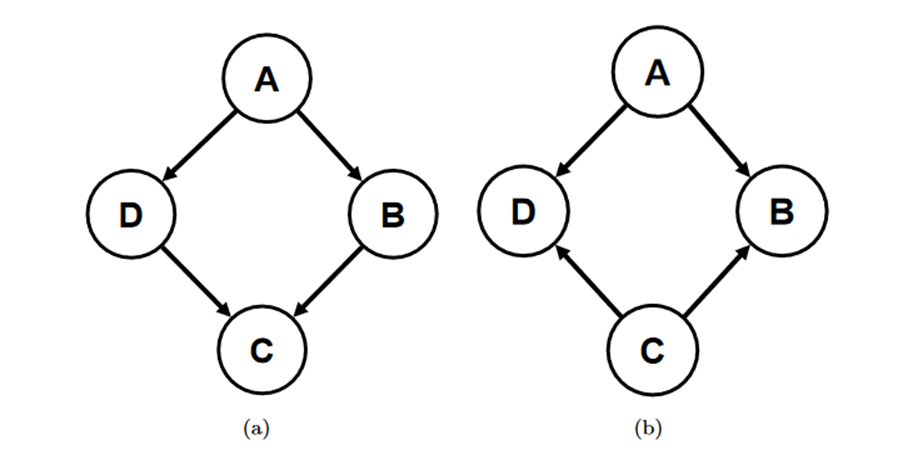

# 1)	[20 pts] Bayesian Networks: Do the following statements hold in each of the above networks? Please explain your reasoning

# a.	A⊥C|B, D
# b.	B⊥D|A, C


Ans:

1) 
- figure a
    - a) A⊥C|B,D True.All the paths are inactive between A and C. 
    - b) B⊥D|A,C False.once C is observed the path between B and D is active.
- figure b
    - a) A⊥C|B,D False. There is an active between A and C once B and D are observed.
    - b) B⊥D|A,C True. All the paths between A and C are inactive.

# 2)	[80 pts] Expectation Maximization (EM): In this question you will implement the EM algorithm for Gaussian Mixture Models. A good read on gaussian mixture EM can be found here. For this problem:
- a.	n is the number of training points
- b.	f is the number of features
- c.	k is the number of gaussians
- d.	X is an n × f matrix of training data
- e.	w is an n × k matrix of membership weights. w(i, j) is the probability that xi was generated by gaussian j
- f.	π is a k × 1 vector of mixture weights (gaussian prior probabilities). πi is the prior probability that any point belongs to cluster i
- g.	μ is a k × f matrix containing the means of each gaussian
- h.	Σ is an f × f × k tensor of covariance matrices. Σ(:, :, i) is the covariance of gaussian i


In [1]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import multivariate_normal

from sklearn.preprocessing import StandardScaler

In [2]:
# load data 
#read data to a dataframe and convert that to a numpy array which we shuffle
df = pd.read_csv('EMData.txt', delim_whitespace=True, skiprows=(0,1,2,3), names=['Xpos','Ypos'])
print(df)
X = df.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = shuffle(X, random_state=22)

          Xpos      Ypos
0     1.343973  0.151104
1     0.962672  0.382781
2     0.502326 -0.181393
3     0.367746  0.804005
4    -0.807914  0.269209
...        ...       ...
1245 -1.394011  4.202079
1246 -3.643562  5.600143
1247 -3.995956  3.211125
1248 -3.005766  1.720398
1249 -3.290476  0.737522

[1250 rows x 2 columns]


In [3]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [4]:
# x0 = Data
# mu = np.mean(x0, axis=0)
# cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

# y = gaussian(x0, mu=mu, cov=cov)
# y

In [5]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [6]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    ## Fill in here
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)

    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']

        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()

    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

In [7]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        ## Fill in here
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)

        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k

        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [8]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    ## Complete the code
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods


In [9]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []
    dim = X.shape[1]

    for i in range(n_epochs):
        clusters_snapshot = []
        
        ## Complete the code
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy(),
                'pi_k': cluster['pi_k']
            })

        history.append(clusters_snapshot)

        expectation_step(X, clusters)
        maximization_step(X, clusters)

        # Extract all the means and covariances
        means = np.array([cluster['mu_k'] for cluster in clusters])
        covariances = np.array([cluster['cov_k'] for cluster in clusters])

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood


        print('Epoch: ', i + 1, ' Log Likelihood: ', np.log(-likelihood))

    scores = np.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [10]:
n_clusters = 3
n_epochs = 100

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X_scaled, n_clusters, n_epochs)

Epoch:  1  Log Likelihood:  8.934384605387129
Epoch:  2  Log Likelihood:  8.66725534238624
Epoch:  3  Log Likelihood:  8.663511966228105
Epoch:  4  Log Likelihood:  8.663132406904234
Epoch:  5  Log Likelihood:  8.66285595051548
Epoch:  6  Log Likelihood:  8.662473926705129
Epoch:  7  Log Likelihood:  8.661934137825254
Epoch:  8  Log Likelihood:  8.661196671496707
Epoch:  9  Log Likelihood:  8.660234532916608
Epoch:  10  Log Likelihood:  8.659045146048877
Epoch:  11  Log Likelihood:  8.657662653984168
Epoch:  12  Log Likelihood:  8.656173020804932
Epoch:  13  Log Likelihood:  8.654723488082622
Epoch:  14  Log Likelihood:  8.653485513668548
Epoch:  15  Log Likelihood:  8.65255812476805
Epoch:  16  Log Likelihood:  8.651919917468486
Epoch:  17  Log Likelihood:  8.651490528399876
Epoch:  18  Log Likelihood:  8.65119673511948
Epoch:  19  Log Likelihood:  8.650988806867714
Epoch:  20  Log Likelihood:  8.650835414014782
Epoch:  21  Log Likelihood:  8.650717071855388
Epoch:  22  Log Likelihood

In [11]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    

    imageio.mimsave('./gmm.gif', images, duration=20)
    plt.show(Image.open('gmm.gif').convert('RGB'))

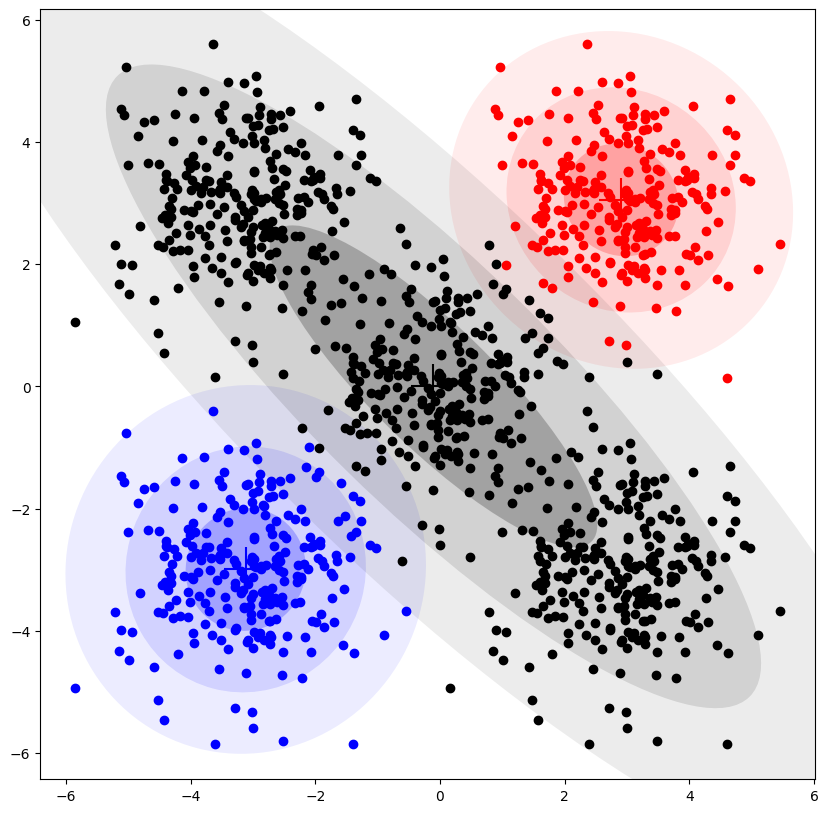

In [12]:
create_cluster_animation(X_scaled, history, scores)